In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'loan-approval-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1226448%2F2047352%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240724%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240724T133753Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbc1d978ad1802f47b5fb9b3df11c0ac12f2f2f550898ff0e4ccc4a2dea39bf971f006505096921574d00f38961c652bcb182a36696fdb3fd636fbb736e38e963e03919aea28cc7e4329dfbc74ad31735ec55e2951c19cd5cfdae496fd93469415a70a70cc351a12ccc2133e9e499379890b7ae1649da93c5137babde19637fa7992545bbd07d1d903633f1bcecda481c415993ed717ec8be83f5c4e164d84b35f954006b6f330c26afd29d08a1a75e1bf51ab511a8515a7a5d65ceb56f3ce88866f14fbb34ba25429d0ed25fff0cb7216c67c0253e3d60ee5872e7f9de303ea796227d15d30ae52bb38329a0c8cbfd4a8e2a9d3f217157ba48ba902289fa8e94'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 13885 bytes downloaded
Downloaded and uncompressed: loan-approval-prediction
Data source import complete.


In [3]:
#Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Reading the dataset

train_dataset = pd.read_csv('/kaggle/input/loan-approval-prediction/Training Dataset.csv')
test_dataset = pd.read_csv('/kaggle/input/loan-approval-prediction/Test Dataset.csv')

train_df = train_dataset.copy()
test_df = test_dataset.copy()
print(train_df.shape)
print(test_df.shape)


(614, 13)
(367, 12)


In [4]:
print('Training-->')
print(train_df.columns)
print('Testing-->')
print(test_df.columns)

Training-->
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Testing-->
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


In [5]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
train_df.shape

(614, 13)

In [7]:
train_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [8]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
train_df['Loan_Status'].value_counts(normalize=True)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

So there were more loan approved than loan rejection.

In [10]:
train_df['Gender'].value_counts(normalize=True)

Gender
Male      0.813644
Female    0.186356
Name: proportion, dtype: float64

In [11]:
#Percentage of Loan approval for Male and Female
Male_approval_percentage = train_df[train_df['Gender']=='Male']['Loan_Status'].value_counts(normalize=True)
Female_approval_percentage = train_df[train_df['Gender']=='Female']['Loan_Status'].value_counts(normalize=True)
print('For Male------>')
print(Male_approval_percentage)
print('For Female------->')
print(Female_approval_percentage)

For Male------>
Loan_Status
Y    0.693252
N    0.306748
Name: proportion, dtype: float64
For Female------->
Loan_Status
Y    0.669643
N    0.330357
Name: proportion, dtype: float64


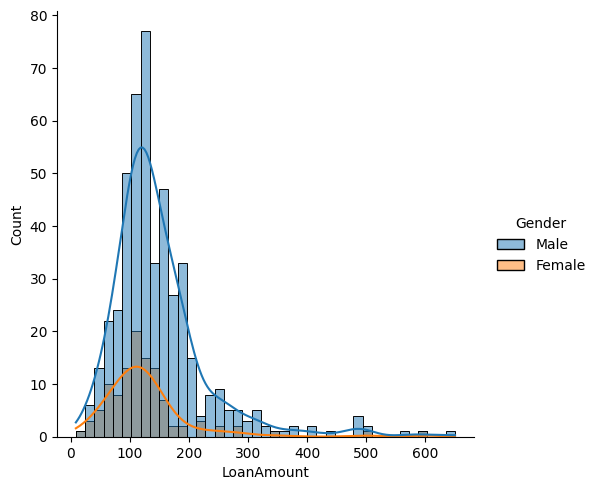

In [12]:
sns.displot(x='LoanAmount', hue='Gender', data=train_df, kde=True)

Statistically, Gender does'nt effect your loan approval chances.

In [13]:
train_df['Married'].value_counts(normalize=True)

Married
Yes    0.651391
No     0.348609
Name: proportion, dtype: float64

In [14]:
#Percentage of Loan approval for Married and Non-Married people

Married_approval_percentage = train_df[train_df['Married']=='Yes']['Loan_Status'].value_counts(normalize=True)
Non_Married_approval_percentage = train_df[train_df['Married']=='No']['Loan_Status'].value_counts(normalize=True)
print('For Male------->')
print(Married_approval_percentage)
print('For Female------->')
print(Non_Married_approval_percentage)

For Male------->
Loan_Status
Y    0.71608
N    0.28392
Name: proportion, dtype: float64
For Female------->
Loan_Status
Y    0.629108
N    0.370892
Name: proportion, dtype: float64


In [15]:
(train_df['Married']=='Yes') & (train_df['Loan_Status']=='Y')

0      False
1      False
2       True
3       True
4      False
       ...  
609    False
610     True
611     True
612     True
613    False
Length: 614, dtype: bool

Here, data is implies that Married people are more likely to get approved for Loan.

In [16]:
train_df[(train_df['Married']=='Yes') & (train_df['Loan_Status']=='Y')]['Gender'].value_counts(normalize=True)

Gender
Male      0.917563
Female    0.082437
Name: proportion, dtype: float64

In [17]:
train_df[(train_df['Married']=='No') & (train_df['Loan_Status']=='Y')]['Gender'].value_counts(normalize=True)

Gender
Male      0.613636
Female    0.386364
Name: proportion, dtype: float64

This dataset consist of ~81% Male, but for Married couple ~91% of loan taker are Male jumping from ~61% Male in Non Married Category.

In [18]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [19]:
train_df['Education'].value_counts(normalize=True)

Education
Graduate        0.781759
Not Graduate    0.218241
Name: proportion, dtype: float64

In [20]:
Graduate_approval_percentage = train_df[train_df['Education']=='Graduate']['Loan_Status'].value_counts(normalize=True)
Non_Graduate_approval_percentage = train_df[train_df['Education']=='Not Graduate']['Loan_Status'].value_counts(normalize=True)
print(Graduate_approval_percentage)
print(Non_Graduate_approval_percentage)

Loan_Status
Y    0.708333
N    0.291667
Name: proportion, dtype: float64
Loan_Status
Y    0.61194
N    0.38806
Name: proportion, dtype: float64


Being a graduate, your Loan Approval percentage jumps by ~10%.

Self_Employed
No     500
Yes     82
Name: count, dtype: int64


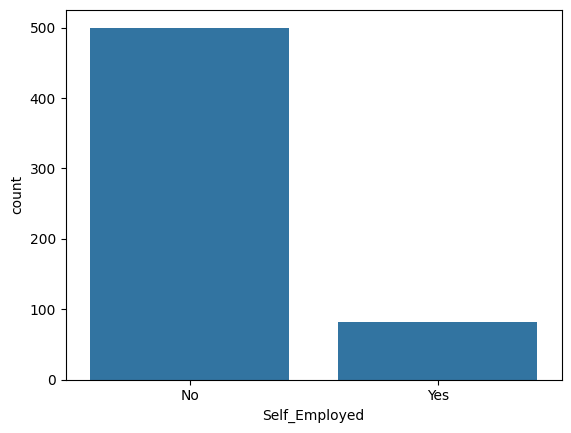

In [21]:
sns.countplot(x='Self_Employed', data=train_df)
print(train_df['Self_Employed'].value_counts())

Self Employed------>
Loan_Status
Y    0.682927
N    0.317073
Name: proportion, dtype: float64
Self UnEmployed------>
Loan_Status
Y    0.686
N    0.314
Name: proportion, dtype: float64


<Axes: xlabel='Loan_Status', ylabel='count'>

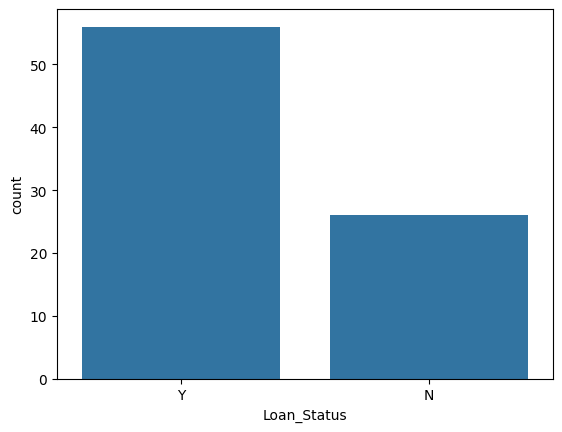

In [22]:
Self_Employed = train_df[train_df['Self_Employed']=='Yes']
Self_UnEmployed = train_df[train_df['Self_Employed']=='No']
print('Self Employed------>')
print(Self_Employed['Loan_Status'].value_counts(normalize=True))
print('Self UnEmployed------>')
print(Self_UnEmployed['Loan_Status'].value_counts(normalize=True))
sns.countplot(x='Loan_Status', data=Self_Employed)

<Axes: xlabel='Loan_Status', ylabel='count'>

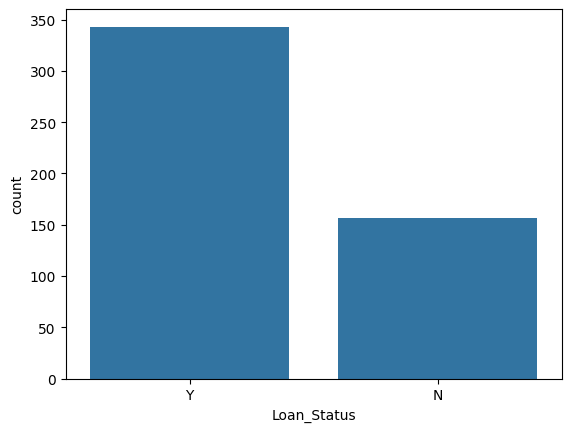

In [23]:
sns.countplot(x='Loan_Status', data=Self_UnEmployed)

Not much differnce approval acceptance whether one is Employed or not.

In [25]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [26]:
train_df['Loan_Amount_Term'].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

Those Term are listed in months, i will be dividing by 12 so that it will be readable.

In [28]:
train_df['Loan_Amount_Term'] = train_df['Loan_Amount_Term']/12
train_df['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
2.500000    512
1.250000     44
3.333333     15
2.083333     13
1.666667      4
0.583333      4
0.833333      3
0.416667      2
0.250000      2
0.083333      1
Name: count, dtype: int64

In [29]:
train_df['Loan_Amount_Term'].value_counts(normalize=True)

Loan_Amount_Term
2.500000    0.853333
1.250000    0.073333
3.333333    0.025000
2.083333    0.021667
1.666667    0.006667
0.583333    0.006667
0.833333    0.005000
0.416667    0.003333
0.250000    0.003333
0.083333    0.001667
Name: proportion, dtype: float64

In [30]:
train_df.groupby('Loan_Amount_Term')['Loan_Status'].value_counts(normalize=True)

Loan_Amount_Term  Loan_Status
0.083333          Y              1.000000
0.250000          N              1.000000
0.416667          Y              1.000000
0.583333          Y              0.750000
                  N              0.250000
0.833333          Y              1.000000
1.250000          Y              0.659091
                  N              0.340909
1.666667          Y              0.750000
                  N              0.250000
2.083333          Y              0.615385
                  N              0.384615
2.500000          Y              0.701172
                  N              0.298828
3.333333          N              0.600000
                  Y              0.400000
Name: proportion, dtype: float64

In [31]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,2.5,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,2.5,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,2.5,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,2.5,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,2.5,1.0,Urban,Y


In [32]:
train_df['Credit_History'].value_counts(normalize=True)

Credit_History
1.0    0.842199
0.0    0.157801
Name: proportion, dtype: float64

In [33]:
train_df.groupby('Credit_History')['Loan_Status'].value_counts(normalize=True)

Credit_History  Loan_Status
0.0             N              0.921348
                Y              0.078652
1.0             Y              0.795789
                N              0.204211
Name: proportion, dtype: float64

People who has good credit and has met guidelance has ~80% of receiving a loan.While if one has'nt paid to guidelines, one has only ~8% of getting a Loan.So credit history really plays an important role

In [34]:
train_df['Property_Area'].value_counts(normalize=True)

Property_Area
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: proportion, dtype: float64

In [35]:
train_df.groupby('Property_Area')['Loan_Status'].value_counts(normalize=True)

Property_Area  Loan_Status
Rural          Y              0.614525
               N              0.385475
Semiurban      Y              0.768240
               N              0.231760
Urban          Y              0.658416
               N              0.341584
Name: proportion, dtype: float64

According to RBI website: Based on the size of the population, a centre, where bank branch is located, is classified either into rural, semi-urban, urban, or metropolitan as under: Rural: population less than 10,000. Semi-Urban: 10,000 and above and less than 1 lakh. Urban: 1 lakh and above and less than 10 lakh.

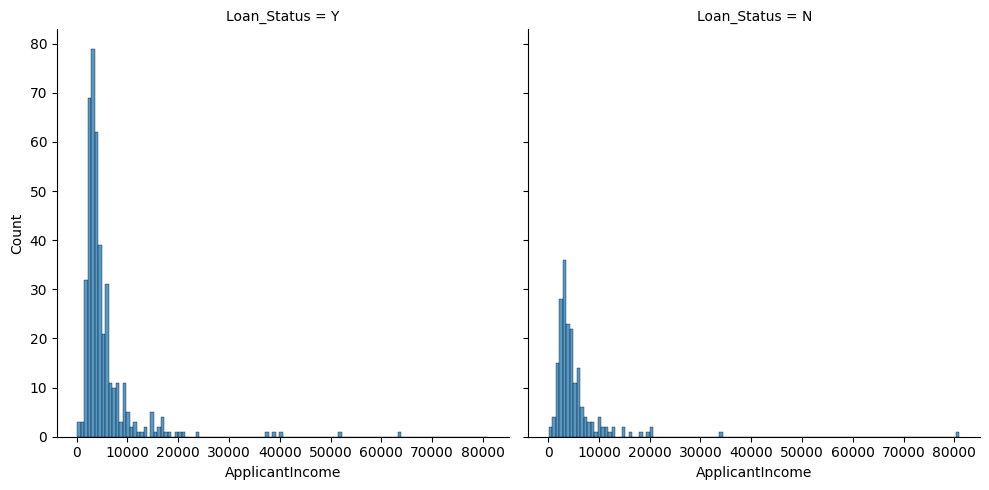

In [36]:
sns.displot(x='ApplicantIncome', data=train_df, col='Loan_Status')

In [37]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,2.5,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,2.5,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,2.5,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,2.5,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,2.5,1.0,Urban,Y


In [38]:
train_df['Dependents'].value_counts(normalize=True)

Dependents
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: proportion, dtype: float64

In [39]:
train_df.groupby('Dependents')['Loan_Status'].value_counts(normalize=True)

Dependents  Loan_Status
0           Y              0.689855
            N              0.310145
1           Y              0.647059
            N              0.352941
2           Y              0.752475
            N              0.247525
3+          Y              0.647059
            N              0.352941
Name: proportion, dtype: float64

No clearly indication that 'Dependents' effects Loan Status.

<Axes: xlabel='ApplicantIncome', ylabel='LoanAmount'>

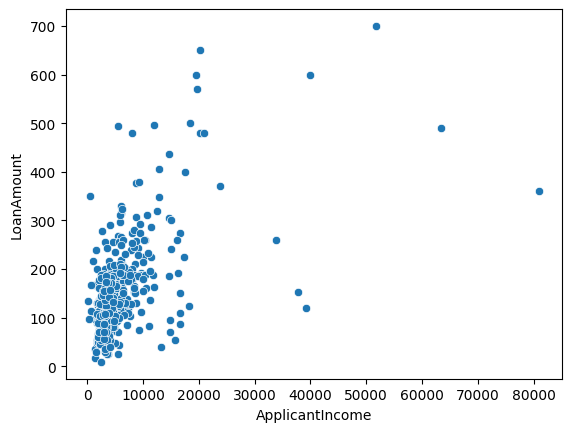

In [41]:
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', data=train_df)

In [42]:
train_df.shape

(614, 13)

0    480
1    121
2     11
3      2
Name: count, dtype: int64

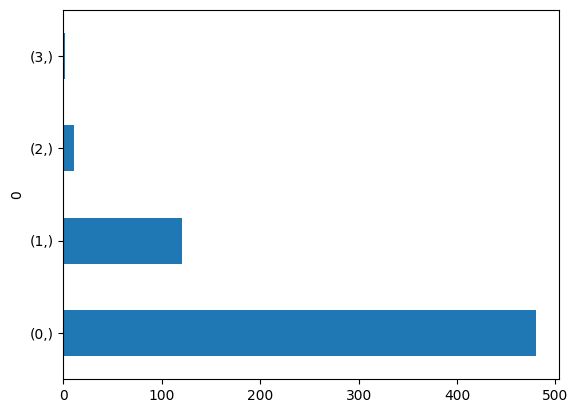

In [43]:
#Checking missing values via row
Row_with_missing_values = pd.DataFrame(train_df.isnull().sum(axis=1))
Row_with_missing_values.value_counts().plot(kind='barh')
Row_with_missing_values.value_counts()

0    289
1     72
2      6
Name: count, dtype: int64

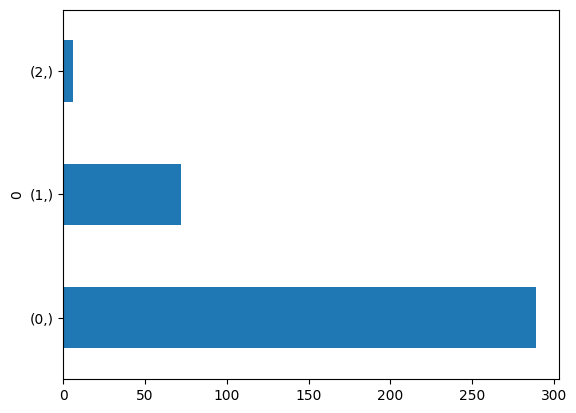

In [44]:
Row_with_missing_values = pd.DataFrame(test_df.isnull().sum(axis=1))
Row_with_missing_values.value_counts().plot(kind='barh')
Row_with_missing_values.value_counts()


In [45]:
#Function for Checking Null Values of Dataset and showing graph


def Null_Analysis(df):
    columns_with_nullValues =  df.columns[df.isnull().any()]
    columns_with_nullValues_count=  df[columns_with_nullValues].isnull().sum()
    columns_with_nullValues_count_percentage= df[columns_with_nullValues].isnull().sum() * 100 / df.shape[0]



    NullValues_Result = pd.concat([columns_with_nullValues_count,columns_with_nullValues_count_percentage], axis=1,join='inner')
    NullValues_Result.columns = ['Count', 'Percentage']
    NullValues_Result['Percentage'] = round(NullValues_Result['Percentage'],2)
    NullValues_Result
    return NullValues_Result

def Null_Analysis_Graph(df):
    NullValues_Result= Null_Analysis(df)
    NullValues_Result['Percentage'].hist(bins=10)
    plt.xlabel('Missing Values Percentages')
    plt.ylabel('Frequency')
    plt.title('Histogram of Missing Values Percentages')
    plt.show()


In [46]:
Null_Analysis(train_df)

,Count,Percentage
Gender,13,2.12
Married,3,0.49
Dependents,15,2.44
Self_Employed,32,5.21
LoanAmount,22,3.58
Loan_Amount_Term,14,2.28
Credit_History,50,8.14


Note that training dataset has 614 instances and 13 features(including target variable).

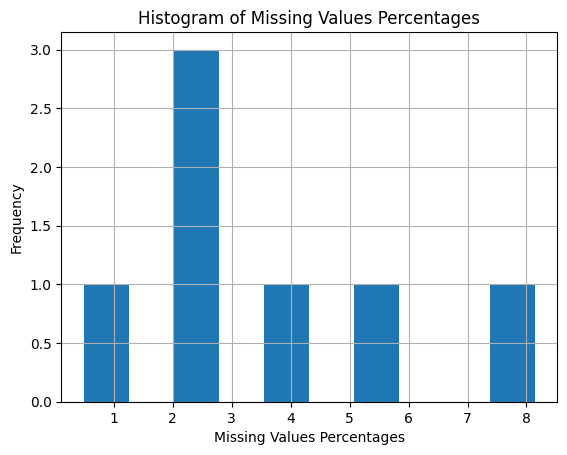

In [47]:
Null_Analysis_Graph(train_df)

In [48]:
Null_Analysis(test_df)

,Count,Percentage
Gender,11,3.00
Dependents,10,2.72
Self_Employed,23,6.27
LoanAmount,5,1.36
Loan_Amount_Term,6,1.63
Credit_History,29,7.90


Note that testing instance has 367 instances.

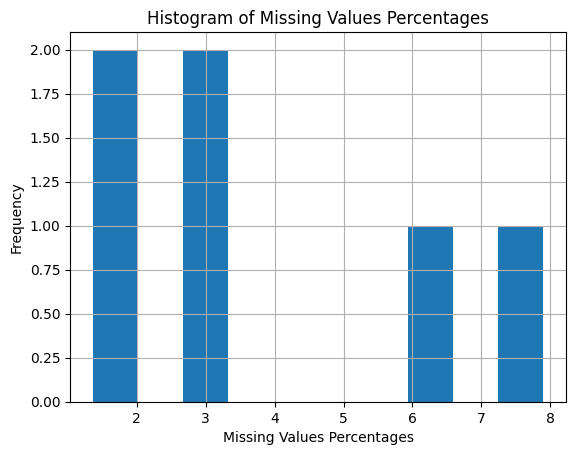

In [49]:
Null_Analysis_Graph(test_df)

In [50]:
Null_Analysis(train_df)

,Count,Percentage
Gender,13,2.12
Married,3,0.49
Dependents,15,2.44
Self_Employed,32,5.21
LoanAmount,22,3.58
Loan_Amount_Term,14,2.28
Credit_History,50,8.14


In [51]:
train_df['Credit_History'].value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

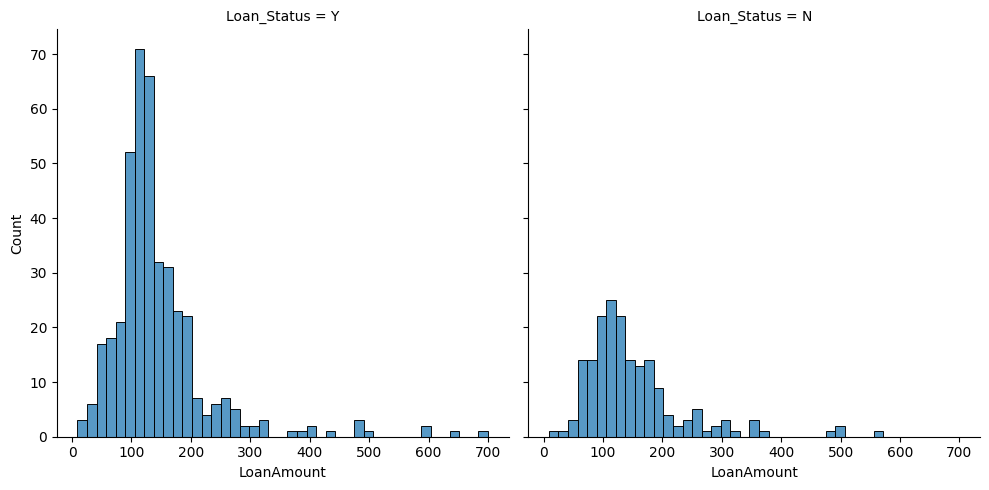

In [52]:
sns.displot(x='LoanAmount', data=train_df, col='Loan_Status')

<Axes: xlabel='LoanAmount'>

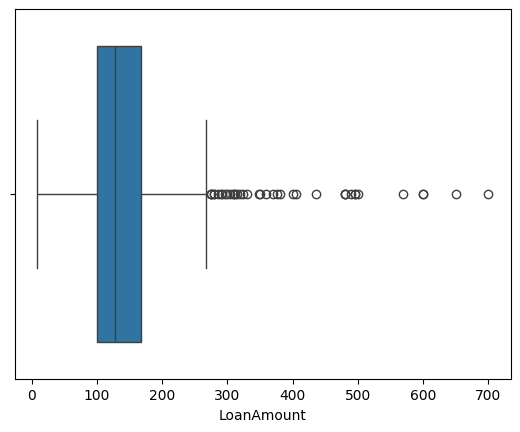

In [53]:
sns.boxplot(x='LoanAmount', data=train_df)

In [54]:
train_df['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

Note that this 'LoanAmount' listed are in thousands.

EDA implications
1.So there were more loan approved than loan rejection.
2.Statistically, Gender does'nt effect your loan approval chances.
3.There were more Male than Female asking for Loan.
4.Here, data is implies that Married people are more likely to get approved for Loan.
5.This dataset consist of ~81% Male, but for Married couple ~91% of loan taker are Male jumping from ~61% Male in Non Married Category.
6.Being a graduate, your Loan Approval percentage jumps by ~10%.
7.Not much differnce approval acceptance whether one is Employed or not.
8.People who has good credit and has met guidelance has ~80% of receiving a loan.While if one has'nt paid to guidelines, one has only ~8% of getting a Loan.So credit history really plays an important role.
9.Though Urban and SemiUrban has better loan acceptance rating, this could be due to the fact that Bank are more likely to give Loan and the dataset has more instances from Urban and SemiUrban.
10.No clearly indication that 'Dependents' effects Loan Status.

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [56]:
#Filling missing values

train_df['Gender'].fillna(train_df['Gender'].mode()[0], inplace=True)
train_df['Married'].fillna(train_df['Married'].mode()[0], inplace=True)
train_df['Dependents'].fillna(train_df['Dependents'].mode()[0], inplace=True)
train_df['Self_Employed'].fillna(train_df['Self_Employed'].mode()[0], inplace=True)
train_df['LoanAmount'].fillna(train_df['LoanAmount'].median(), inplace=True)
train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].median(), inplace=True)
train_df['Credit_History'].fillna(train_df['Credit_History'].median(), inplace=True)

test_df['Gender'].fillna(train_df['Gender'].mode()[0], inplace=True)
test_df['Dependents'].fillna(train_df['Dependents'].mode()[0], inplace=True)
test_df['Self_Employed'].fillna(train_df['Self_Employed'].mode()[0], inplace=True)
test_df['LoanAmount'].fillna(train_df['LoanAmount'].median(), inplace=True)
test_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].median(), inplace=True)
test_df['Credit_History'].fillna(train_df['Credit_History'].median(), inplace=True)


In [57]:
test_df.isnull().sum().sum()

0

In [58]:
train_df.isnull().sum().sum()

0

In [59]:
# store columns with specific data type
integer_columns = train_df.select_dtypes(include=['int64']).columns
float_columns = train_df.select_dtypes(include=['float64']).columns
object_columns = train_df.select_dtypes(include=['object']).columns

print("No of Integer type columns: {}".format(len(integer_columns)))
print("No of Float type columns: {}".format(len(float_columns)))
print("No of String type columns: {}".format(len(object_columns)))

No of Integer type columns: 1
No of Float type columns: 4
No of String type columns: 8


In [60]:
object_columns = list(object_columns)
object_columns.remove('Loan_ID')
object_columns.remove('Loan_Status')

In [61]:
print(object_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [62]:
print(object_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [63]:
#Checking if Test Data Set has any values in categorical features which is not present in Training Data Set

for object_col in object_columns:
    print(train_df[object_col].unique())
    print(test_df[object_col].unique())

['Male' 'Female']
['Male' 'Female']
['No' 'Yes']
['Yes' 'No']
['0' '1' '2' '3+']
['0' '1' '2' '3+']
['Graduate' 'Not Graduate']
['Graduate' 'Not Graduate']
['No' 'Yes']
['No' 'Yes']
['Urban' 'Rural' 'Semiurban']
['Urban' 'Semiurban' 'Rural']


In [64]:
#Modifying some values in Features

train_df['Dependents'] = train_df['Dependents'].replace(['3+'],['3'])
test_df['Dependents'] = test_df['Dependents'].replace(['3+'],['3'])
train_df['Dependents'] = train_df['Dependents'].astype('int64')
test_df['Dependents'] = test_df['Dependents'].astype('int64')

train_df['Gender'] = train_df['Gender'].replace(['Male','Female'],[1,0])
test_df['Gender'] = test_df['Gender'].replace(['Male','Female'],[1,0])

train_df['Married'] = train_df['Married'].replace(['Yes','No'],[1,0])
test_df['Married'] = test_df['Married'].replace(['Yes','No'],[1,0])

train_df['Education'] = train_df['Education'].replace(['Graduate','Not Graduate'],[1,0])
test_df['Education'] = test_df['Education'].replace(['Graduate','Not Graduate'],[1,0])

train_df['Self_Employed'] = train_df['Self_Employed'].replace(['Yes','No'],[1,0])
test_df['Self_Employed'] = test_df['Self_Employed'].replace(['Yes','No'],[1,0])


In [65]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,1,0,5849,0.0,128.0,2.5,1.0,Urban,Y
1,LP001003,1,1,1,1,0,4583,1508.0,128.0,2.5,1.0,Rural,N
2,LP001005,1,1,0,1,1,3000,0.0,66.0,2.5,1.0,Urban,Y
3,LP001006,1,1,0,0,0,2583,2358.0,120.0,2.5,1.0,Urban,Y
4,LP001008,1,0,0,1,0,6000,0.0,141.0,2.5,1.0,Urban,Y


In [66]:
#Splitting the data Set
X = train_df.iloc[:,1:-1]
y = train_df.iloc[:,-1:]

In [67]:
y['Loan_Status'].unique()

array(['Y', 'N'], dtype=object)

In [68]:
y_numbered = y.copy()
y_numbered['Loan_Status'] = y_numbered.replace(['Y','N'],[1,0])

In [69]:
#Creating dummies for Categorical features


dummies = pd.get_dummies(X['Property_Area'])

#Dropping the categorical feature columns from the dataset , and then concatinating the dummies

X.drop(['Property_Area'], axis=1, inplace=True)
X_dummied = pd.concat([X,dummies], axis='columns')

X_dummied.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Rural,Semiurban,Urban
0,1,0,0,1,0,5849,0.0,128.0,2.5,1.0,False,False,True
1,1,1,1,1,0,4583,1508.0,128.0,2.5,1.0,True,False,False
2,1,1,0,1,1,3000,0.0,66.0,2.5,1.0,False,False,True
3,1,1,0,0,0,2583,2358.0,120.0,2.5,1.0,False,False,True
4,1,0,0,1,0,6000,0.0,141.0,2.5,1.0,False,False,True


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dummied, y_numbered, test_size=0.3, random_state=42)

In [71]:
print('X train shape: ',X_train.shape)
print('y train shape: ',y_train.shape)
print('X test shape: ',X_test.shape)
print('y test shape: ',y_test.shape)

X train shape:  (429, 13)
y train shape:  (429, 1)
X test shape:  (185, 13)
y test shape:  (185, 1)


In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [73]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=21)
KNN.fit(X_train_normalized, np.ravel(y_train))
print(KNN.score(X_train_normalized, y_train))

0.7575757575757576


In [74]:
print(KNN.score(X_test_normalized, y_test))

0.7135135135135136


Now different Lenders has different strategic on choosing the metric for choosing the right candidate to approve for Loan,



1.If you are an representative of an government program helping out to people in needs, then you want as much poor people to get the loan as possible, so for metric choosing sensitivity or recall is the right path. But if you have an limited buget, then with sensitity you also want to take precision into consideration so f1score.

In [75]:
#Performing Grid Search to find the optimal hyper parameters
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 51,2))
p_range=[1,2] #1 for manhattan distance 2 for ecludiean distance
param_grid = {
               'n_neighbors':k_range,
               'p':p_range,

}
grid = GridSearchCV(KNN, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
grid_search=grid.fit(X_train_normalized, np.ravel(y_train))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [76]:
print(grid_search.best_params_)

{'n_neighbors': 3, 'p': 2}


In [77]:
#Best model

KNN = KNeighborsClassifier(n_neighbors=3, p=2)
KNN.fit(X_train_normalized, np.ravel(y_train))
print(KNN.score(X_train_normalized, y_train))

0.8601398601398601


In [78]:
print(KNN.score(X_test_normalized, y_test))

0.7513513513513513


In [79]:
from sklearn.metrics import confusion_matrix
y_predict = KNN.predict(X_test_normalized)
confusion_matrix(y_test,y_predict, labels=[1,0])

array([[110,  10],
       [ 36,  29]])

In [80]:
specificity = 29/(29+36)  #(TN)/(TN+FP)
sensitivity = 110/(110+10) #(TP)/(TP+FN) also a.k.a recall
accuracy = (110+29)/(110+36+10+29) #(TP+TN)/(TP+TN+FP+FN)
precision = (110)/(110+36) #(TP)/(TP+FP)
print(specificity)
print(sensitivity)
print(accuracy)
print(precision)

0.4461538461538462
0.9166666666666666
0.7513513513513513
0.7534246575342466


This KNN model has decent accuracy 75.1%, low specificity 44% but really high 91% sensitivity.